#  Erdbebenlokalisierung mit Triangulation
Erdbebenwellen breiten sich in alle Richtungen aus und werden von seismischen Stationen an der Oberfläche registriert. Um den Ort des Erdbebens zu bestimmen, nutzen Seismologen vor die P-Wellen (Primärwellen), da sie die schnellsten seismischen Wellen sind und somit als erstes an den Stationen ankommen. S-Wellen können ebenso benutzt werden, es dauert jedoch länger bis diese aufgezeichnet werden.

Die Triangulation ist eine einfache Methode zur Bestimmung des Erdbebenepizentrums. Dabei werden die Ankunftszeiten der P-Wellen (und/oder S-Wellen) an mehreren Stationen (Seismometern) verglichen. Aus den Zeitdifferenzen kann man die Entfernung jeder Station zum Erdbeben berechnen. Zeichnet man um jede Station einen Kreis mit diesem Abstand, ergibt der Schnittpunkt der Kreise die ungefähre Lage des Epizentrums.

In dieser Aufgabe betrachten wir 5 Erdbeben, und lokalisieren sie jeweils mittels 3 Stationen.

In [1]:
# Importe
import matplotlib.pyplot as plt
import numpy as np
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, FloatText, HBox, Label, interactive_output, Output
from IPython.display import display


# Erdbebendaten werden vom ETH Server bezogen
client = Client("ETH")

In [49]:
# Funktionen für das Notebook (nicht-ändern)

# Download der Daten und Prozessierung
def get_data(station_data,origin_time):
    # Daten Download
    # Station 1
    st1 = client.get_waveforms(
        network=station_data[0]["network"],
        station=station_data[0]["station"],
        location="*",
        channel=station_data[0]["channel"],
        starttime=origin_time-20,
        endtime=origin_time+40, attach_response=True,
    )

    # Station 2
    st2 = client.get_waveforms(
        network=station_data[1]["network"],
        station=station_data[1]["station"],
        location="*",
        channel=station_data[1]["channel"],
        starttime=origin_time-20,
        endtime=origin_time+40, attach_response=True,
    )

    # Station 3
    st3 = client.get_waveforms(
        network=station_data[2]["network"],
        station=station_data[2]["station"],
        location="*",
        channel=station_data[2]["channel"],
        starttime=origin_time-20,
        endtime=origin_time+40, attach_response=True,
    )

    # Vorprozessierung
    st1.remove_response(output="VEL")
    st2.remove_response(output="VEL")
    st3.remove_response(output="VEL")

    # Bandpass Filter
    st1.filter("bandpass", freqmin=2, freqmax=30)
    st2.filter("bandpass", freqmin=2, freqmax=30)
    st3.filter("bandpass", freqmin=2, freqmax=30)

    return st1.trim(origin_time, origin_time+20), st2.trim(origin_time, origin_time+20), st3.trim(origin_time, origin_time+20)

def km_to_deg(kilometer):  
    # stark vereinfachte Umwandlung zur groben Abschätzung
    return kilometer / 111  

# Interactive Plot Funktion
def plot_with_start_slider(timeseries, initial_start=1, time_range=[0, 10]):
    """
    Plot a timeseries with an interactive slider and numeric box 
    to set the onset (start) point. Returns a dict with updated value.
    
    Parameters
    ----------
    timeseries : obspy.Stream or obspy.Trace
        Seismic timeseries. If a Stream is given, the first Trace will be used.
    """
    # Handle Stream or Trace
    if hasattr(timeseries, "traces"):
        tr = timeseries[0]
    else:
        tr = timeseries

    t = tr.times()
    data = tr.data
    dt = 1.0 / tr.stats.sampling_rate
    onset_val = {'start': initial_start}  # mutable container for updated value

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(t, data, lw=1, color="k")
    onset_line = ax.axvline(initial_start, color='darkred', lw=2, ls="--")
    label = ax.text(initial_start, max(data)*0.9, "Start Signal", color='darkred',
                    rotation=90, va='top', ha='right')

    ax.set_xlim(time_range)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude [m/s]")
    ax.set_title(tr.id)
    onset_slider = FloatSlider(
        value=initial_start,
        min=t[0],
        max=t[-1],
        step=dt,
        description='Start'
    )
    onset_box = FloatText(value=initial_start)
    unit_label = Label(" [s]")

    # Update functions
    def update_onset(val):
        x = val['new']
        onset_line.set_xdata([x, x])
        label.set_x(x)
        fig.canvas.draw_idle()
        onset_box.value = x
        onset_val['start'] = x  # update container

    def update_box(change):
        x = change['new']
        onset_slider.value = x
        onset_val['start'] = x  # update container

    onset_slider.observe(update_onset, names='value')
    onset_box.observe(update_box, names='value')

    display(HBox([onset_slider, onset_box, unit_label]))
    plt.show()

    return onset_val  # contains the current value

from ipywidgets import FloatSlider, FloatText, HBox, VBox, interactive_output
import matplotlib.pyplot as plt
from IPython.display import display

def plot_with_p_s(timeseries, initial_p=1, initial_s=3, time_range=[0, 10]):
    """
    Plot a timeseries with interactive sliders to select P- and S-wave onsets.
    Returns a dict with the currently selected P- and S-times.
    """
    # Handle Stream or Trace
    if hasattr(timeseries, "traces"):
        tr = timeseries[0]
    else:
        tr = timeseries

    t = tr.times()
    data = tr.data
    dt = 1.0 / tr.stats.sampling_rate
    values = {'P': initial_p, 'S': initial_s}

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(t, data, lw=1, color="k")
    p_line = ax.axvline(initial_p, color='darkred', lw=2, ls="--")
    s_line = ax.axvline(initial_s, color='darkgreen', lw=2, ls="--")
    p_label = ax.text(initial_p, max(data)*0.9, "P", color='darkred', rotation=90, va='top', ha='right')
    s_label = ax.text(initial_s, max(data)*0.9, "S", color='darkgreen', rotation=90, va='top', ha='right')

    ax.set_xlim(time_range)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude [m/s]")
    ax.set_title(tr.id)
    plt.show()

    # Widgets
    p_slider = FloatSlider(value=initial_p, min=t[0], max=t[-1], step=dt, description='P')
    p_box = FloatText(value=initial_p, description='P')
    s_slider = FloatSlider(value=initial_s, min=t[0], max=t[-1], step=dt, description='S')
    s_box = FloatText(value=initial_s, description='S')

    # Update function
    def update(P, S):
        values['P'] = P
        values['S'] = S
        p_line.set_xdata([P, P])
        p_label.set_x(P)
        s_line.set_xdata([S, S])
        s_label.set_x(S)
        fig.canvas.draw_idle()
        return values

    out = interactive_output(update, {'P': p_slider, 'S': s_slider})

    display(VBox([
        HBox([p_slider, p_box]),
        HBox([s_slider, s_box]),
        out
    ]))

    # Synchronize slider and text box
    def sync_slider_box(slider, box):
        def on_slider_change(change):
            box.value = change['new']
        def on_box_change(change):
            slider.value = change['new']
        slider.observe(on_slider_change, names='value')
        box.observe(on_box_change, names='value')

    sync_slider_box(p_slider, p_box)
    sync_slider_box(s_slider, s_box)

    return values


def get_station_info(station_data):
    # Wir sammeln noch die Koordinaten der Stationen (Lat/Lon)
    station_info = []
    for stat in station_data:
        inventory = client.get_stations(network=stat["network"],
                                        station=stat["station"],
                                        channel=stat["channel"],
                                        level="station",
                                        starttime=origin_time,endtime=origin_time+20,)
        
        sta = inventory[0][0]  # Network -> Station
        
        station_info.append([stat["station"],sta.latitude,sta.longitude])
    return station_info

# START AUFGABE
Wähle nacheinander Erdbeben 1-5 und lokalisiere mittels Triangulation. Die Herdzeit ist gegeben.

# Part 1: Erdbeben Lokalisierung mit P-Welle und Herdzeit

In [41]:
# Wähle Erdbeben 1,2,3,4, oder 4
earthquake_number = 1

if earthquake_number==1: 
    # Beben 1
    origin_time = UTCDateTime("2025-07-21T10:52:16")   # start time
    station_data = [
        {"network": "CH", "station": "SFRS", "channel":"HGZ"},
        {"network": "CH", "station": "SINS", "channel":"HGZ"},
        {"network": "CH", "station": "FIESA", "channel":"HHZ"},
    ]
elif earthquake_number==2: # geht nicht
    # Beben 2
    origin_time = UTCDateTime("2025-07-21T19:17:25")   
    station_data = [
        {"network": "CH", "station": "VANNI", "channel":"HHZ"},
        {"network": "CH", "station": "LKBD2", "channel":"HHZ"},
        {"network": "CH", "station": "EMBD", "channel":"HHZ"},
    ]
elif earthquake_number==3:
    # Beben 3
    origin_time = UTCDateTime("2025-07-13T12:16:29")   # start time
    station_data = [
        {"network": "CH", "station": "SGRA", "channel":"HGZ"},
        {"network": "CH", "station": "MMK", "channel":"HHZ"},
        {"network": "CH", "station": "FIESA", "channel":"HHZ"},
    ]
elif earthquake_number==4:
    # Beben 4
    origin_time = UTCDateTime("2025-07-28T13:48:21")   # start time
    station_data = [
        {"network": "CH", "station": "SRFW", "channel":"HGZ"},
        {"network": "CH", "station": "SRHB", "channel":"HGZ"},
        {"network": "CH", "station": "SULZ", "channel":"HHZ"},
    ]

elif earthquake_number==5:
    # Beben 5
    origin_time = UTCDateTime("2025-07-29T13:03:12")   # start time
    station_data = [
        {"network": "CH", "station": "SENIN", "channel":"HHZ"},
        {"network": "CH", "station": "GRYON", "channel":"HHZ"},
        {"network": "CH", "station": "STSW2", "channel":"HGZ"},
    ]
else:
    print("Wähle Erdbeben 1,2,3,4, oder 4")


station_info = get_station_info(station_data)

### Seismogramme herunterladen, prozessieren, und überprüfen

In [42]:
# Daten Download der vertikal Komponente
st1, st2, st3 = get_data(station_data,origin_time)

print("Seismogramme in Streams enthalten") 
print("mit Network/Station/Channel Code; sowie Start und Ende des Seismograms; Abtastfrequenz [Hz], und Anzahl Zeitschritte in Zeitreihe")
print(st1)
print(st2)
print(st3)

Seismogramme in Streams enthalten
mit Network/Station/Channel Code; sowie Start und Ende des Seismograms; Abtastfrequenz [Hz], und Anzahl Zeitschritte in Zeitreihe
1 Trace(s) in Stream:
CH.SFRS..HGZ | 2025-07-21T10:52:16.000000Z - 2025-07-21T10:52:36.000000Z | 250.0 Hz, 5001 samples
1 Trace(s) in Stream:
CH.SINS..HGZ | 2025-07-21T10:52:16.000000Z - 2025-07-21T10:52:36.000000Z | 250.0 Hz, 5001 samples
1 Trace(s) in Stream:
CH.FIESA..HHZ | 2025-07-21T10:52:16.000000Z - 2025-07-21T10:52:36.000000Z | 200.0 Hz, 4001 samples


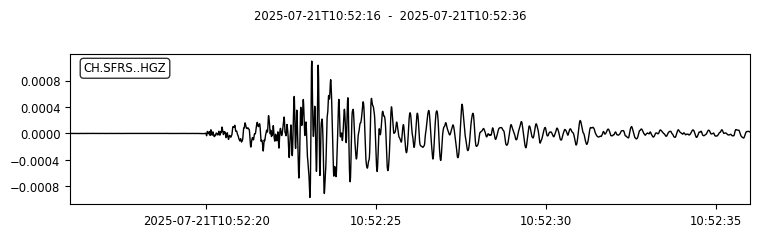

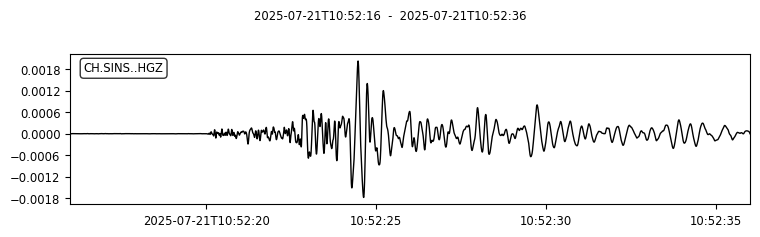

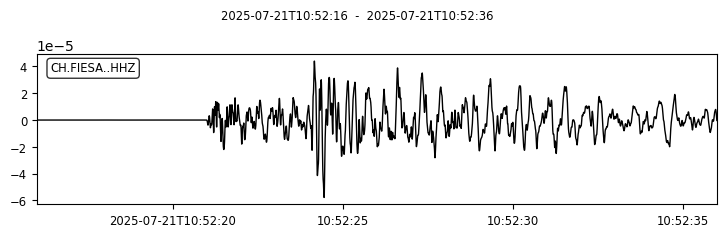

In [43]:
# Daten Plotten, die Einheit ist m/s (Bodenbewegung)
plt.close("all")
%matplotlib inline

st1.plot()
st2.plot()
st3.plot();

### Wähle für jede Aufzeichnung die Startzeit des Erdbebensignals (Beginn der P-Welle, da diese die schnellste Welle ist).

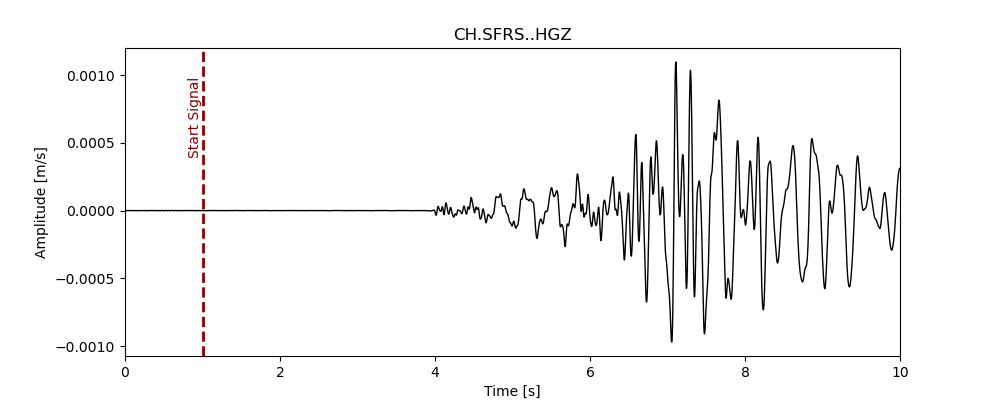

In [44]:
# Bestimme Start des Erdbebensignals an Station 1
%matplotlib widget

start_station1 = 1 # 
# Ändere Länge des Seismograms im Plot mittels time_range = [0,10] in Sekunden
selected_start_station1 = plot_with_start_slider(st1[0],initial_start=start_station1,time_range=[0,10])

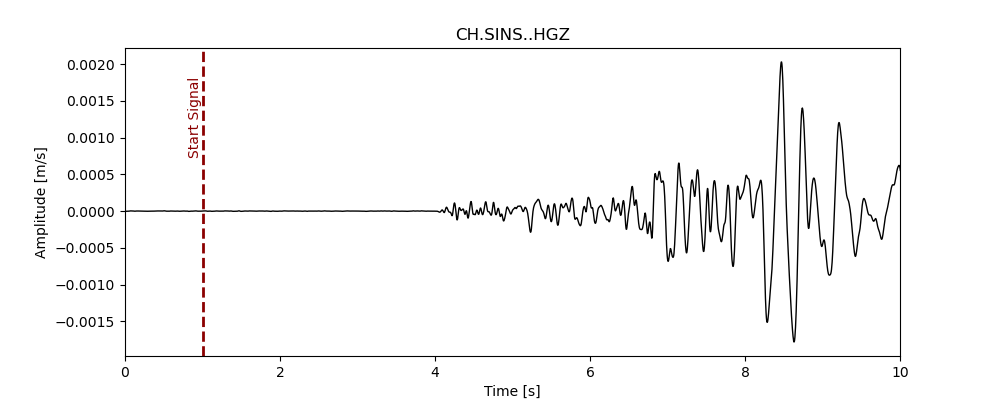

In [45]:
# Bestimme Start des Erdbebensignals an Station 2
%matplotlib widget

start_station2 = 1
selected_start_station2 = plot_with_start_slider(st2[0],initial_start=start_station2,time_range=[0,10])

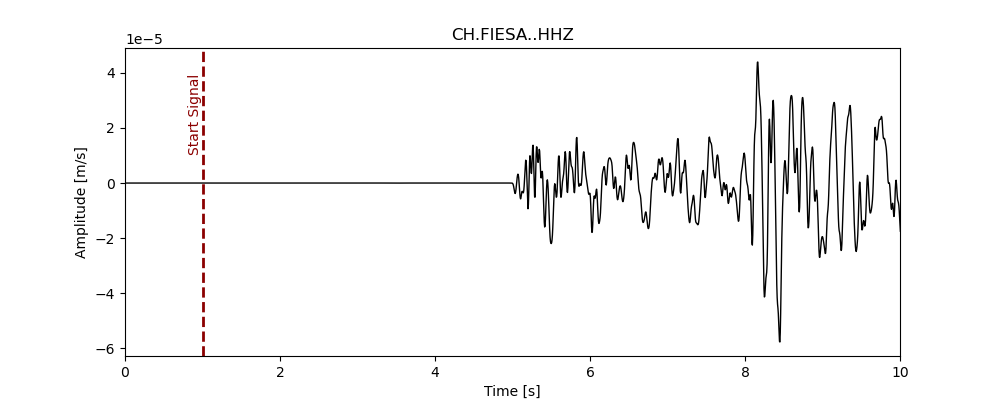

In [36]:
# Bestimme Start des Erdbebensignals an Station 3
%matplotlib widget

start_station3 = 1
selected_start_station3 = plot_with_start_slider(st3[0],initial_start=start_station3,time_range=[0,10])

In [46]:
start_station1 = selected_start_station1["start"]
start_station2 = selected_start_station2["start"]
start_station3 = selected_start_station3["start"]

print("Gewählte Laufzeiten (Station 1,2,3)")
print(station_data[0]["station"] + f": {start_station1:.1f} [s]")
print(station_data[1]["station"] + f": {start_station2:.1f} [s]")
print(station_data[2]["station"] + f": {start_station3:.1f} [s]")

Gewählte Laufzeiten (Station 1,2,3)
SFRS: 3.9 [s]
SINS: 1.0 [s]
FIESA: 5.0 [s]


In [38]:
# Bestimme Distanzen
# Hinweis: die ausgewählte Zeit ist relativ zur Herdzeit des Bebens
vp = 6 # Nutze typische P Wellengeschwindigkeit in [km]; 
# Denke daran dass die Geschwindigkeit auch mit der lokalen Geologie variiert.
# Beachte auch, dass Erdbebenwellen mit grösserer Distanz typischer Weise durch tiefere, schneller Schichten propagieren
distance_station1 = vp * start_station1
distance_station2 = vp * start_station2
distance_station3 = vp * start_station3

print(f"Geschätzte Distanz von Station 1 [km]: {distance_station1:.1f}")
print(f"Geschätzte Distanz von Station 2 [km]: {distance_station2:.1f}")
print(f"Geschätzte Distanz von Station 3 [km]: {distance_station3:.1f}")


Geschätzte Distanz von Station 1 [km]: 23.4
Geschätzte Distanz von Station 2 [km]: 24.4
Geschätzte Distanz von Station 3 [km]: 30.2


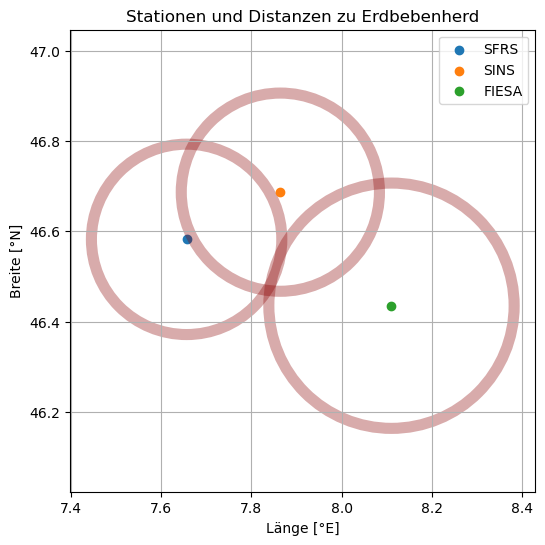

In [47]:
import matplotlib.patches as patches  

# Schliesse interaktive Plots
plt.close('all')
%matplotlib inline


fig, ax = plt.subplots(figsize=(6,6))

for i, stat in enumerate(station_info):
    ax.scatter(stat[2], stat[1], label=stat[0])

    distance = [distance_station1, distance_station2, distance_station3][i]
    circle = patches.Circle((stat[2], stat[1]), radius=km_to_deg(distance), color='darkred', fill=False, lw=8,alpha=0.33)
    ax.add_patch(circle)

ax.axis('equal')
ax.legend()
ax.set_xlabel("Länge [°E]")
ax.set_ylabel("Breite [°N]")
ax.set_title("Stationen und Distanzen zu Erdbebenherd")
ax.grid()
plt.show()


Fragen zur Aufgabe:
1. Kann jedes Beben gleich gut lokalisiert werden? Wenn nein, was sidn die Gründe?
2. Die Triangulation ist eine sehr vereinfachte Methode zur Lokalisierung der Erdbebenhypozentren. Welche Faktoren werden hierbei nicht beachtet?
3. In dieser Übung war die Herdzeit gegeben und die Laufzeit der Wellen vom Erdbebenherd zur Station können direkt bestimmt werden. Wie könnte das Beben lokalisiert werden wenn die Herdzeit nicht bekannt ist?


In [48]:
# Beben 1: 46.540 N 7.859 E
# Beben 2: 46.277 N 7.639 E
# Beben 3: 46.192 N 7.903 E
# Beben 4: 47.618 7.824 E - schwieriger aufgrund Geometrie der Stationen
# Beben 5: 46.299 N 7.269 E - schwierig da hohes Rauschen

# Part 2: Erdbeben Lokalisierung mit P und S-Welle, ohne Herdzeit

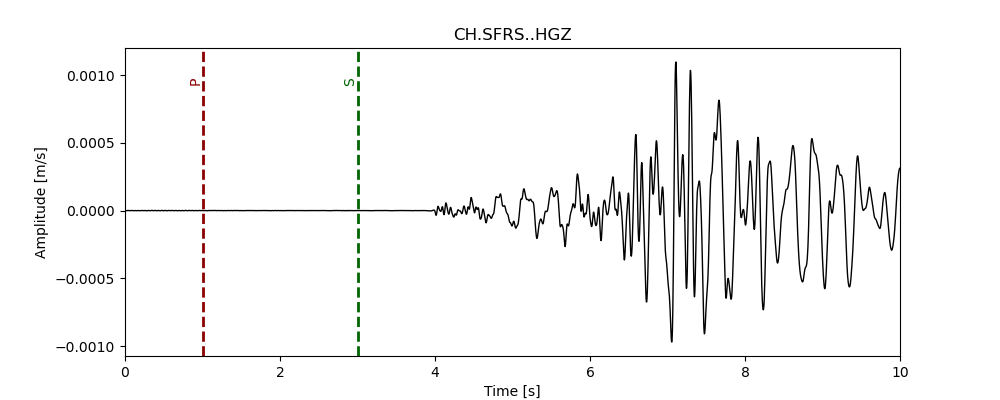

In [58]:
%matplotlib widget
# Station 1, bestimme P und S Einsätze
selected_p_s_station1 = plot_with_p_s(st1[0], initial_p=1, initial_s=3, time_range=[0, 10])


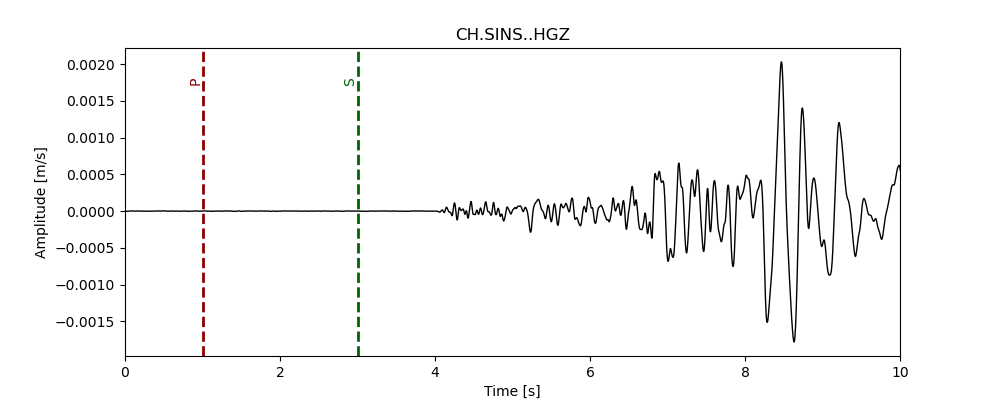

In [59]:
%matplotlib widget
# Station 2, bestimme P und S Einsätze
selected_p_s_station2 = plot_with_p_s(st2[0], initial_p=1, initial_s=3, time_range=[0, 10])


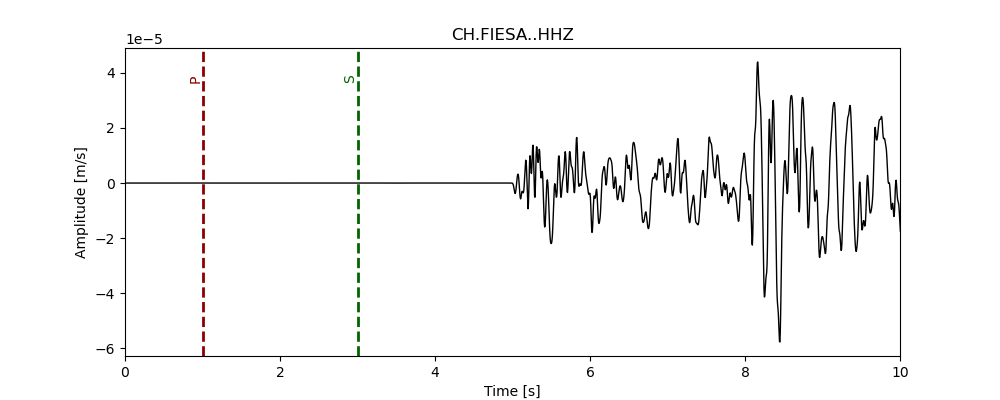

In [60]:
%matplotlib widget
# Station 3, bestimme P und S Einsätze
selected_p_s_station3 = plot_with_p_s(st3[0], initial_p=1, initial_s=3, time_range=[0, 10])

In [61]:
# Bestimme Distanzen
# Hinweis: die ausgewählte Zeit ist relativ zur Herdzeit des Bebens
vp = 6 # Nutze typische P Wellengeschwindigkeit in [km];
vs = vp/1.73 # Nutze typische P Wellengeschwindigkeit in [km];

# Denke daran dass die Geschwindigkeit auch mit der lokalen Geologie variiert.
# Beachte auch, dass Erdbebenwellen mit grösserer Distanz typischer Weise durch tiefere, schneller Schichten propagieren
distance_station1 = get_distance(selected_p_s_station1["P"],selected_p_s_station1["S"],vp,vs)
distance_station2 = get_distance(selected_p_s_station1["P"],selected_p_s_station2["S"],vp,vs)
distance_station3 = get_distance(selected_p_s_station1["P"],selected_p_s_station3["S"],vp,vs)

print(f"Geschätzte Distanz von Station 1 [km]: {distance_station1:.1f}")
print(f"Geschätzte Distanz von Station 2 [km]: {distance_station2:.1f}")
print(f"Geschätzte Distanz von Station 3 [km]: {distance_station3:.1f}")

Geschätzte Distanz von Station 1 [km]: 20.4
Geschätzte Distanz von Station 2 [km]: 23.0
Geschätzte Distanz von Station 3 [km]: 32.4


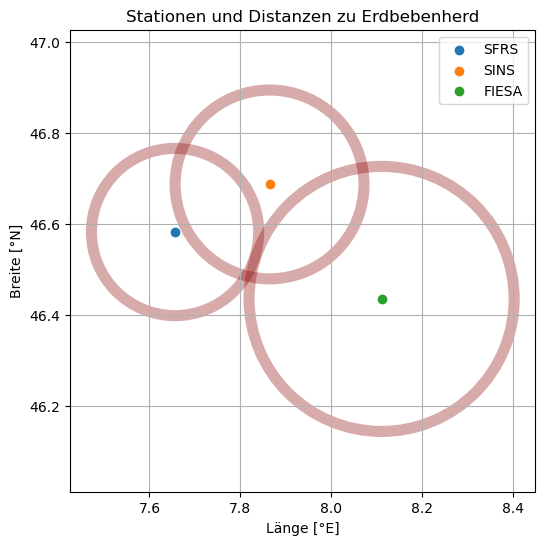

In [62]:
import matplotlib.patches as patches

# Schliesse interaktive Plots
plt.close('all')
%matplotlib inline


fig, ax = plt.subplots(figsize=(6,6))

for i, stat in enumerate(station_info):
    ax.scatter(stat[2], stat[1], label=stat[0])

    distance = [distance_station1, distance_station2, distance_station3][i]
    circle = patches.Circle((stat[2], stat[1]), radius=km_to_deg(distance), color='darkred', fill=False, lw=8,alpha=0.33)
    ax.add_patch(circle)

ax.axis('equal')
ax.legend()
ax.set_xlabel("Länge [°E]")
ax.set_ylabel("Breite [°N]")
ax.set_title("Stationen und Distanzen zu Erdbebenherd")
ax.grid()
plt.show()

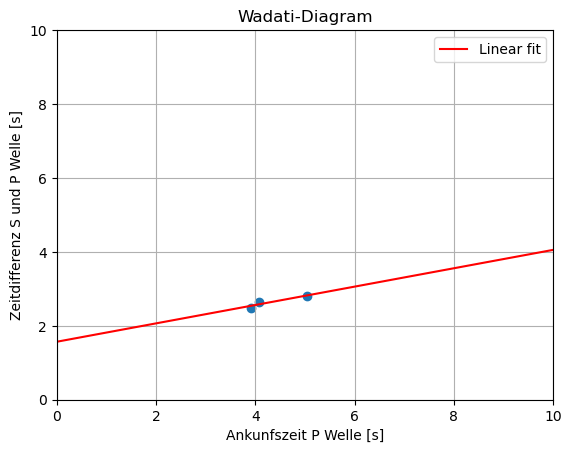

In [63]:
# Bestimmung Herdzeit - Erstelle ein Wadati-Diagram
p_times, sp_times = [], []
for ps in [selected_p_s_station1, selected_p_s_station2, selected_p_s_station3]:
    p = ps["P"]
    s = ps["S"]
    sp_times.append(ps["S"]-p)
    p_times.append(p)

plt.scatter(p_times, sp_times,)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel("Ankunfszeit P Welle [s]")
plt.ylabel("Zeitdifferenz S und P Welle [s]")
plt.title("Wadati-Diagram")


m, b = np.polyfit(p_times, sp_times, 1)
x = np.linspace(0,10,11)
y_fit = m * x + b

plt.plot(x, y_fit, color='red', label=f'Linear fit')
plt.legend()
plt.grid()